In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/tmp/.fastai/data/camvid/codes.txt'),
 PosixPath('/tmp/.fastai/data/camvid/labels'),
 PosixPath('/tmp/.fastai/data/camvid/images'),
 PosixPath('/tmp/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/tmp/.fastai/data/camvid/images/0006R0_f02310.png'),
 PosixPath('/tmp/.fastai/data/camvid/images/0006R0_f03120.png'),
 PosixPath('/tmp/.fastai/data/camvid/images/0006R0_f02880.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/tmp/.fastai/data/camvid/labels/0006R0_f03240_P.png'),
 PosixPath('/tmp/.fastai/data/camvid/labels/0001TP_007710_P.png'),
 PosixPath('/tmp/.fastai/data/camvid/labels/0001TP_007200_P.png')]

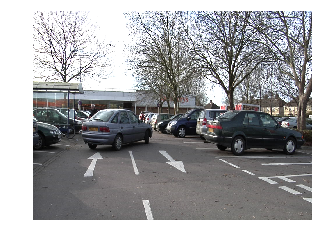

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

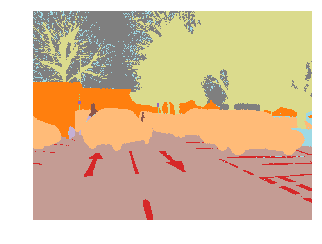

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          [21, 30, 30,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [12]:
size = src_size//2
bs=8

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

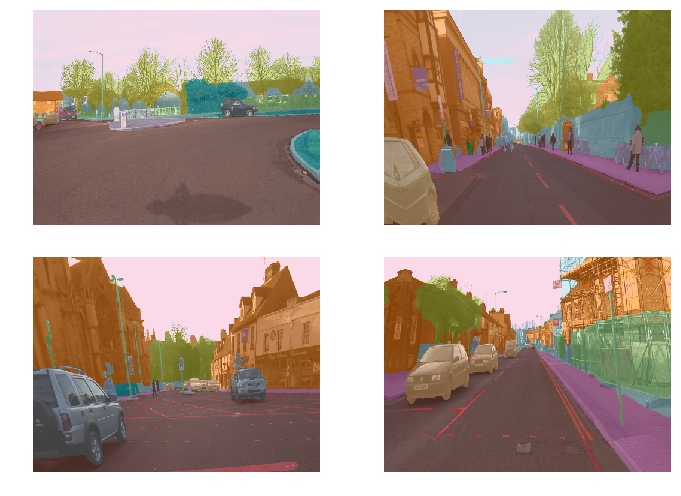

In [15]:
data.show_batch(2, figsize=(10,7))

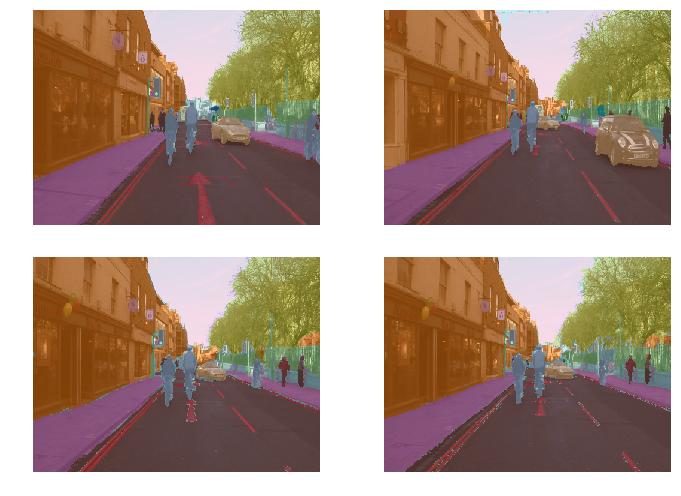

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid

In [19]:
wd=1e-2

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 82976577.25it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


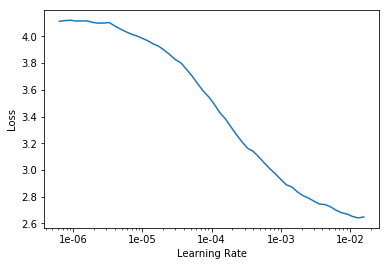

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
# lr = slice(1e-06,1e-03)

In [23]:
learn.fit_one_cycle(10, slice(1e-06,1e-03), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
1,1.398570,1.040521,0.762058,04:40
2,0.925630,0.703565,0.824709,04:32
3,0.751924,0.595527,0.847899,04:32
4,0.633828,0.499312,0.860105,04:31
5,0.589015,0.464790,0.875930,04:28
6,0.553507,0.435767,0.871243,04:28
7,0.563320,0.505620,0.866092,04:28
8,0.511570,0.412420,0.886527,04:27
9,0.476555,0.414614,0.890870,04:26
10,0.422017,0.331361,0.904700,04:26


In [24]:
path = "."

In [25]:
learn.save('stage-1')

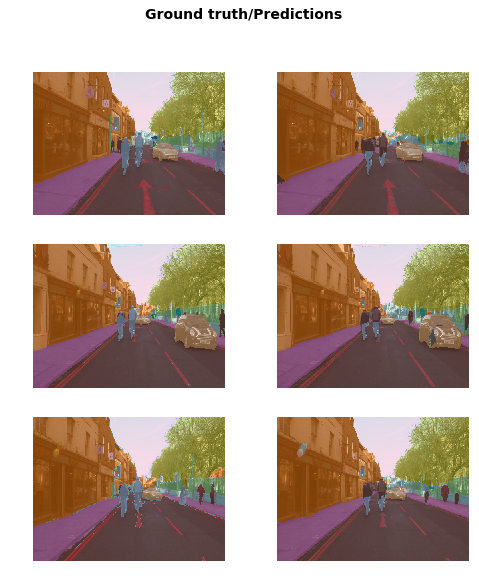

In [26]:
learn.show_results(rows=3, figsize=(8,9))

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


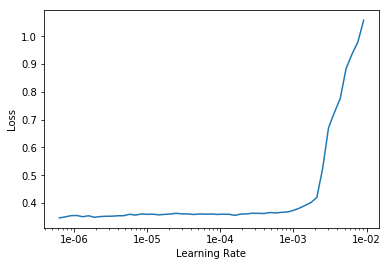

In [28]:
lr_find(learn)
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(12, slice(1e-5,1e-4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.356735,0.313755,0.908751,04:33
2,0.346208,0.306641,0.910613,04:34
3,0.344245,0.299048,0.914273,04:33
4,0.337347,0.292195,0.916391,04:34
5,0.325078,0.287712,0.917876,04:34
6,0.322646,0.288477,0.917389,04:34
7,0.314694,0.289398,0.916427,04:35
8,0.303480,0.281046,0.920056,04:33
9,0.295776,0.290859,0.916411,04:35
10,0.284570,0.273707,0.923062,04:35


In [30]:
learn.save('stage-2')